# MODEL RSA1

#### Representational dissimilarity between correct and incorrect trials
#### Contains only conditional trials without intervening BLs
#### Accounts for last three noisy volumes in Lvl 1 analysis (FSL ROI -- ExtractROI)

## Compares activation for regions of interest using binarized masks:
#### Hippocampus (FS labels: hippocampus [17, 53])
#### Medial PFC (FS labels: caudal anterior cingulate, rostral anterior cingulate)
#### Dorsal Caudate (hand-drawn by Mandy)
#### Putamen (FS labels: putamen [12, 51])
#### Ventral Visual Area (FS labels: fusiform, lingual,  parahippocampal [1007, 2007, 1013, 2013, 1016, 2016]
#### Dorsolateral PFC (FS labels: caudal middle frontal, lateral orbital frontal, rostral middle frontal [1003, 2003, 1012, 2012, 1027, 2027]

In [1]:
import os
import re
from os.path import join
from glob import glob
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')
sns.set_style("white")

sids = ['WMAZE_001', 'WMAZE_004', #removed 002,005,006,007,020,023 for lacking 1 or more all_before_incorr
        'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze' 
mask_filenames = []
cope_files = []

for i, SID in enumerate(sids):
    mask_filenames_glob = glob(proj_dir+'/roi_analysis/hamm/fb4c/anat_masks/_subject_id_'+SID+'/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_filenames_glob))
    rsc_filenames_glob = glob(proj_dir+'/mask/rsc_inepi/'+SID+'/rsc_temp2epi/_subject_id_'+SID+'/_targ2EPI*/*')
    mask_filenames[i].append(rsc_filenames_glob[0])
    subjcopes_glob = glob(proj_dir + '/frstlvl/learning/RSA1/cond/' +SID+ 
                          '/modelfit/contrasts/_estimate_model*/cope??_B*')
    cope_files.append(sorted(subjcopes_glob))
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 12:
        print(SID), len(cope_files[-1])

## Cell to double-check the array indexing

In [2]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7]) 

(0, 'lh-all_mPFC_warped')
(1, 'lh-dmPFC_warped')
(2, 'lh-hippocampus_warped')
(3, 'lh-mPFC_fs-3reg_warped')
(4, 'lh-mPFC_fs_warped')
(5, 'lh-mPFC_lausanne_warped')
(6, 'lh-motor_warped')
(7, 'lh_caudate_anat_mask_warped')
(8, 'lh_vocc_warped')
(9, 'rh_caudate_anat_mask_warped')
(10, 'rh-all_mPFC_warped')
(11, 'rh-dmPFC_warped')
(12, 'rh-hippocampus_warped')
(13, 'rh-mPFC_fs-3reg_warped')
(14, 'rh-mPFC_fs_warped')
(15, 'rh-mPFC_lausanne_warped')
(16, 'rh-motor_warped')
(17, 'rh_vocc_warped')
(18, 'lh-putamen_warped')
(19, 'lh_dlpfc_warped')
(20, 'lh_dlpfc_warped')
(21, 'rh-putamen_warped')
(22, 'CCOPY_T_wmaze_template_trans')


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [3]:
all_data = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'dlpfc', 'vocc', 'rsc']:
    all_data['{0}'.format(r)] = {'run1_corr':[], 'run1_incorr':[], 'run2_corr':[], 'run2_incorr':[], #set1
                                 'run3_corr':[], 'run3_incorr':[], 'run4_corr':[], 'run4_incorr':[], #set2
                                 'run5_corr':[], 'run5_incorr':[], 'run6_corr':[], 'run6_incorr':[]} #set3
for i in range(len(sids)):
    lh_hp_img = nb.load(mask_filenames[i][2])
    rh_hp_img = nb.load(mask_filenames[i][12])
    lh_mpfc_img = nb.load(mask_filenames[i][4])
    rh_mpfc_img = nb.load(mask_filenames[i][14])
    lh_caud_img = nb.load(mask_filenames[i][7])
    rh_caud_img = nb.load(mask_filenames[i][9])
    lh_put_img = nb.load(mask_filenames[i][18])
    rh_put_img = nb.load(mask_filenames[i][21])
    lh_dlpfc_img = nb.load(mask_filenames[i][19])
    rh_dlpfc_img = nb.load(mask_filenames[i][20])
    lh_vocc_img = nb.load(mask_filenames[i][8])
    rh_vocc_img = nb.load(mask_filenames[i][17])
    bi_rsc_img = nb.load(mask_filenames[i][22])
    
    run1_corr_img = None
    run1_incorr_img = None
    run2_corr_img = None
    run2_incorr_img = None
    run3_corr_img = None
    run3_incorr_img = None
    run4_corr_img = None
    run4_incorr_img = None
    run5_corr_img = None
    run5_incorr_img = None
    run6_corr_img = None
    run6_incorr_img = None
    
    set1 = [x for x in cope_files[i] if 'model0' in x or 'model1' in x]
    set2 = [x for x in cope_files[i] if 'model2' in x or 'model3' in x]
    set3 = [x for x in cope_files[i] if 'model4' in x or 'model5' in x]
    
    for j, frst_run in enumerate(range(1,6,2)):            
        if len(eval('set{0}'.format(j+1))) != 4:
            for key in ["hp","mpfc","caud","put","dlpfc","vocc","rsc"]:
                for acc in ["corr", "incorr"]:                      
                    all_data['{0}'.format(key)]['run{0}_{1}'.format(frst_run,acc)].append("nan")
                    all_data['{0}'.format(key)]['run{0}_{1}'.format(frst_run+1,acc)].append("nan")
        else: 
            exec('run{0}_corr_img = nb.load(set{1}[0])'.format(frst_run,j+1))
            exec('run{0}_incorr_img = nb.load(set{1}[1])'.format(frst_run,j+1))
            exec('run{0}_corr_img = nb.load(set{1}[2])'.format(frst_run+1,j+1))
            exec('run{0}_incorr_img = nb.load(set{1}[3])'.format(frst_run+1,j+1))    
    
    for key in ['hp', 'mpfc', 'caud', 'put', 'dlpfc', 'vocc']:
        for run in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
            for acc in ['corr', 'incorr']: 
                if eval('{0}_{1}_img'.format(run,acc)) == None:
                    continue
                else:
                    lh_data = eval('{0}_{1}_img.get_data()[lh_{2}_img.get_data() > 0.]'.format(run,acc,key))
                    rh_data = eval('{0}_{1}_img.get_data()[rh_{2}_img.get_data() > 0.]'.format(run,acc,key))
                    bihemi_data = np.concatenate((lh_data, rh_data)) 
                    all_data['{0}'.format(key)]['{0}_{1}'.format(run,acc)].append(bihemi_data)                    
    for run in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
        for acc in ['corr', 'incorr']:
            if eval('{0}_{1}_img'.format(run,acc)) == None:
                continue
            else:
                bihemi_data = eval('{0}_{1}_img.get_data()[bi_rsc_img.get_data()[:,:,:,0] > 0.]'.format(run,acc))
                all_data['rsc']['{0}_{1}'.format(run,acc)].append(bihemi_data)                                     
for key in all_data:
    exec('{0}_df = pd.DataFrame(all_data["{0}"])'.format(key))
all_data_df = pd.DataFrame(all_data)                       

In [4]:
#all_data_df

In [5]:
all_corrs = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'dlpfc', 'vocc', 'rsc']:
    all_corrs['{0}'.format(r)] = {'s1r1':[],'s1r2':[], 's2r1':[], 's2r2':[], 's3r1':[], 's3r2':[]}

sids = ['WMAZE_001', 'WMAZE_004', #removed 002,005,006,007,020,023 for lacking 1 or more all_before_incorr
        'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

for x, SID in enumerate(sids):
    for key in all_data:
        for i, frst_run in enumerate(range(1,6,2)):
            if type(eval('{0}_df["run{1}_corr"][x]'.format(key,i*2+1))) is str:
                continue
            else:
                exec('all_corrs["{0}"]["s{1}r1"].append(1-pearsonr({0}_df["run{3}_corr"][{2}],{0}_df["run{3}_incorr"][{2}])[0])'.format(key,i+1,x,i*2+1))
                exec('all_corrs["{0}"]["s{1}r2"].append(1-pearsonr({0}_df["run{3}_corr"][{2}],{0}_df["run{3}_incorr"][{2}])[0])'.format(key,i+1,x,i*2+2))
all_corrs_df = pd.DataFrame(all_corrs)

In [6]:
#all_corrs_df

### Performance Calculation

In [7]:
all_prop_corr = {'s1r1':[], 's1r2':[], 's2r1':[], 's2r2':[],'s3r1':[], 's3r2':[]}
stim_sets = ['1', '2', '3']

for SID in sids:
    sub_dir = '/home/data/madlab/data/mri/wmaze/scanner_behav/{0}/'.format(SID)
    dir_file = sorted(glob(join(sub_dir,'{0}_wmazebl_2015*.txt'.format(SID))))   
    early_runs = []
    late_runs = []
    for i, curr_set in enumerate(stim_sets):
        run1 = pd.read_table(dir_file[i*2]) #create dataframe for text files to extract EVS
        run1 = run1[:-3] #removal of the last 3 trials to avoid scanner artifact
        run2 = pd.read_table(dir_file[i*2+1])
        run2 = run2[:-3]
     
        trialtype1 = run1['TrialType'].values
        correct1 = run1['Correct'].values
        trial_shift1 = trialtype1[1:] #shift TrialType back and insert dummy (-1) in last index
        trial_shift1 = np.append(trial_shift1, -1)
        correct_shift1 = correct1[1:] #shift Correct back and insert dummy (-1) in last index
        correct_shift1 = np.append(correct_shift1, -1)        
        corr1 = np.where(((trial_shift1=='B') & (correct_shift1==1)) & (trialtype1!='BL'))[0]
        incorr1 = np.where(((trial_shift1=='B') & (correct_shift1==0)) & (trialtype1!='BL'))[0]
        curr_prop_corr1 = len(corr1)/float(len(corr1) + len(incorr1))
        
        trialtype2 = run2['TrialType'].values
        correct2 = run2['Correct'].values
        trial_shift2 = trialtype2[1:] #shift TrialType back and insert dummy (-1) in last index
        trial_shift2 = np.append(trial_shift2, -1)
        correct_shift2 = correct2[1:] #shift Correct back and insert dummy (-1) in last index
        correct_shift2 = np.append(correct_shift2, -1)        
        corr2 = np.where(((trial_shift2=='B') & (correct_shift2==1)) & (trialtype2!='BL'))[0]
        incorr2 = np.where(((trial_shift2=='B') & (correct_shift2==0)) & (trialtype2!='BL'))[0]
        curr_prop_corr2 = len(corr2)/float(len(corr2) + len(incorr2))
 
        if curr_prop_corr1 == 1.0 or curr_prop_corr2 == 1.0 or curr_prop_corr1 == 0.0 or curr_prop_corr2 == 0.0:
            continue
        else:
            all_prop_corr['s{0}r1'.format(curr_set)].append(curr_prop_corr1)
            all_prop_corr['s{0}r2'.format(curr_set)].append(curr_prop_corr2)
#for key in all_prop_corr:                
    #print key, len(all_prop_corr['{0}'.format(key)])

#### Shapiro's Test of Normality

In [8]:
for key in all_corrs:
    for key2 in all_corrs['{0}'.format(key)]:
        if stats.shapiro(all_corrs['{0}'.format(key)]['{0}'.format(key2)])[1] < 0.045:
            print key, key2, stats.shapiro(all_corrs['{0}'.format(key)]['{0}'.format(key2)])[1], "<--- **" 
        else:
            print key, key2, stats.shapiro(all_corrs['{0}'.format(key)]['{0}'.format(key2)])[1]

dlpfc s1r2 0.625789284706
dlpfc s1r1 0.538092374802
dlpfc s2r1 0.0704152807593
dlpfc s2r2 0.846063613892
dlpfc s3r1 0.805759906769
dlpfc s3r2 0.275677114725
caud s1r2 0.126008123159
caud s1r1 0.128706976771
caud s2r1 0.519211888313
caud s2r2 0.45284768939
caud s3r1 0.23219409585
caud s3r2 0.0561682246625
hp s1r2 0.928908646107
hp s1r1 0.175713568926
hp s2r1 0.639452636242
hp s2r2 0.154843777418
hp s3r1 0.615021109581
hp s3r2 0.893863797188
vocc s1r2 0.99815505743
vocc s1r1 0.992585718632
vocc s2r1 0.035002425313 <--- **
vocc s2r2 0.387648433447
vocc s3r1 0.674296796322
vocc s3r2 0.330008476973
mpfc s1r2 0.909015953541
mpfc s1r1 0.632918596268
mpfc s2r1 0.0635718479753
mpfc s2r2 0.613461434841
mpfc s3r1 0.541815638542
mpfc s3r2 0.308605521917
rsc s1r2 0.665000081062
rsc s1r1 0.557314395905
rsc s2r1 0.639459431171
rsc s2r2 0.0673484876752
rsc s3r1 0.0672512874007
rsc s3r2 0.950640380383
put s1r2 0.151694789529
put s1r1 0.185241639614
put s2r1 0.534394085407
put s2r2 0.747698068619
put s3

## Hippocampus

Dissimilarity
Mean s1r1:  0.529489374587
STD s1r1:  0.119986436864

Mean s1r2:  0.585049123902
STD s1r2:  0.205567393871

Mean s2r1:  0.581515769341
STD s2r1:  0.17232306577

Mean s2r2:  0.617994986475
STD s2r2:  0.158711529996

Mean s3r1:  0.573787257075
STD s3r1:  0.192520429826

Mean s3r2:  0.643337570929
STD s3r2:  0.230943364357



/home/data/madlab/envs/wmaze_madlab_env/lib/python2.7/site-packages/matplotlib/patches.py:102: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/home/data/madlab/envs/wmaze_madlab_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Set1 Run1 vs. Run2:
t-test (-0.79301027464776186, 0.44200512731951991)
Cohen's d =  -0.449862679144


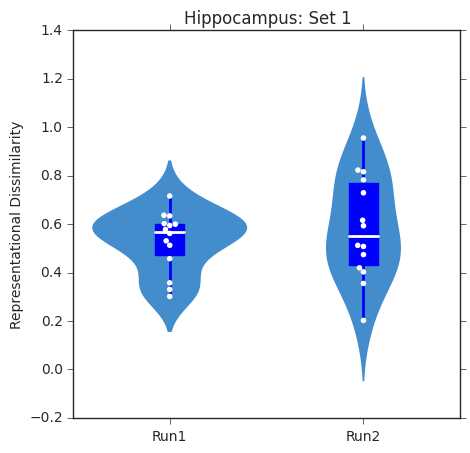

Set2 Run1 vs. Run2:
t-test (-0.60688977518679987, 0.55437592481915221)
Cohen's d =  -0.300094444977


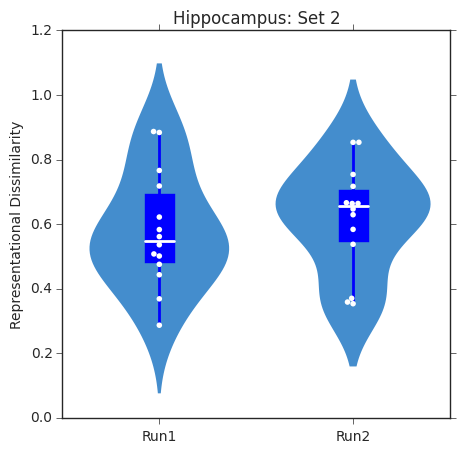

Set3 Run1 vs. Run2:
t-test (-1.314795010448913, 0.21130145057254324)
Cohen's d =  -0.445815379849


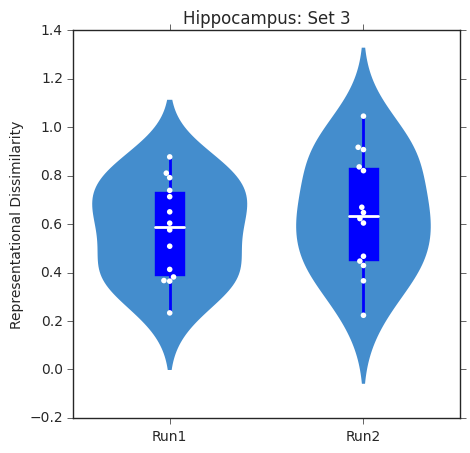

In [9]:
print "Dissimilarity"
for key in ["s1r1", "s1r2","s2r1","s2r2","s3r1","s3r2"]:
    print "Mean {0}: ".format(key), np.mean(all_corrs_df['hp']['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(all_corrs_df['hp']['{0}'.format(key)])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1', 'Run2']
    hp_allsubjs = [all_corrs_df['hp']['s{0}r1'.format(i+1)], all_corrs_df['hp']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=hp_allsubjs, color="#278fea", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(hp_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
               whiskerprops=dict(color="blue", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = hp_allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity")
    ax.set_title("Hippocampus: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.ttest_rel(all_corrs_df['hp']['s{0}r1'.format(i+1)], all_corrs_df['hp']['s{0}r2'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
        print "t-test", stats.ttest_rel(all_corrs_df['hp']['s{0}r1'.format(i+1)], all_corrs_df['hp']['s{0}r2'.format(i+1)])[:], "<---- **"
    else:
        print "t-test", stats.ttest_rel(all_corrs_df['hp']['s{0}r1'.format(i+1)], all_corrs_df['hp']['s{0}r2'.format(i+1)])[:]
    cohens_d = ((np.average(all_corrs_df['hp']['s{0}r1'.format(i+1)]) 
                 - np.average(all_corrs_df['hp']['s{0}r2'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['hp']['s{0}r1'.format(i+1)], ddof = 1)) 
                    ** 2 + np.std(all_corrs_df['hp']['s{0}r2'.format(i+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1C_hpc_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (-0.075527789039343013, 0.79747451077184506)
Late - Run1: (0.36295881435511357, 0.20213485707579096)


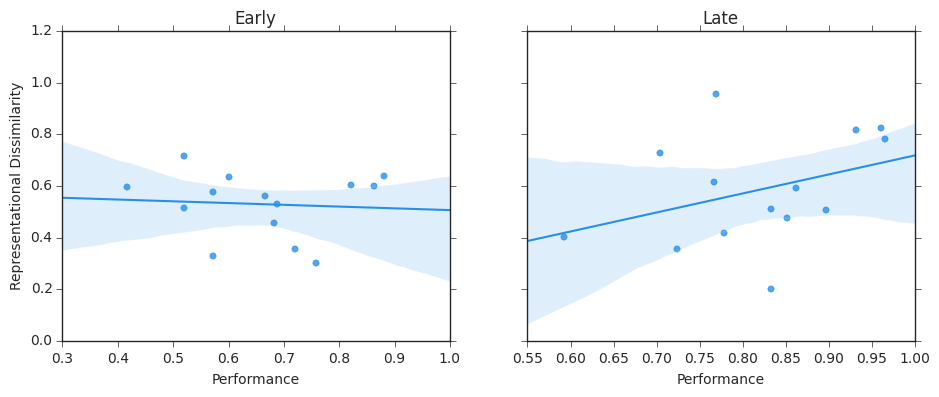

SET 2
Early - Run1: (0.23786156925096996, 0.41285955191055457)
Late - Run1: (0.54735414204479882, 0.042775766289281064)


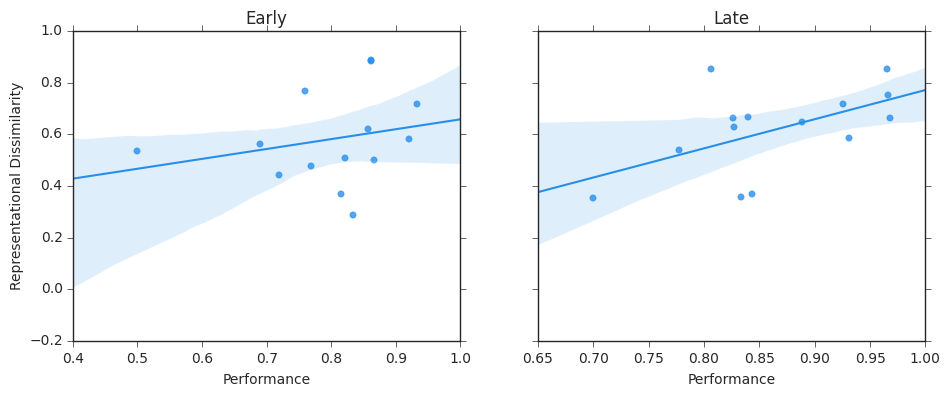

SET 3
Early - Run1: (0.64730411054508596, 0.012330859986334323)
Late - Run1: (0.60468554955331633, 0.021976124797049832)


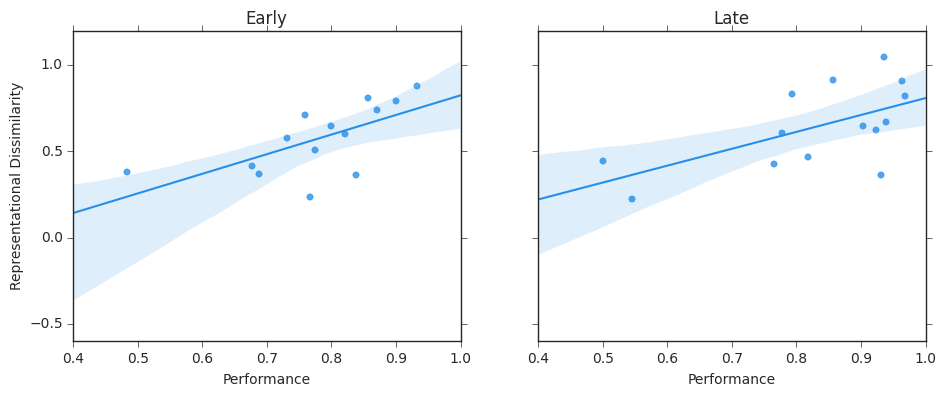

In [10]:
for i in range(3):
    hp_early_plot = {}
    hp_early_plot['brain'] = all_corrs_df['hp']['s{0}r1'.format(i+1)]
    hp_early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    hp_early_plot = pd.DataFrame(hp_early_plot)
    hp_late_plot = {}
    hp_late_plot['brain'] = all_corrs_df['hp']['s{0}r2'.format(i+1)]
    hp_late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    hp_late_plot = pd.DataFrame(hp_late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(hp_early_plot['brain'],hp_early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(hp_early_plot['brain'],hp_early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(hp_early_plot['brain'],hp_early_plot['behavior'])[:]
    if pearsonr(hp_late_plot['brain'],hp_late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(hp_late_plot['brain'],hp_late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(hp_late_plot['brain'],hp_late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11, 4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = hp_early_plot, color = "#278fea", ax = ax1)
    ax1.set_ylabel('Representational Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = hp_late_plot, color = "#278fea", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2C_hpc_run{0}.png".format(i+1), dpi = 800)
    plt.show()

## Medial PFC

Dissimilarity
Mean s1r1:  0.493304693273
STD s1r1:  0.137435619691

Mean s1r2:  0.582400782832
STD s1r2:  0.211298019553

Mean s2r1:  0.490114086441
STD s2r1:  0.15383145772

Mean s2r2:  0.608755101317
STD s2r2:  0.253293471773

Mean s3r1:  0.554119314998
STD s3r1:  0.252868319451

Mean s3r2:  0.573558339417
STD s3r2:  0.254698287888

Set1 Run1 vs. Run2:
Wilcoxon (34.0, 0.24549352944751968)
Cohen's d =  -0.68122159054


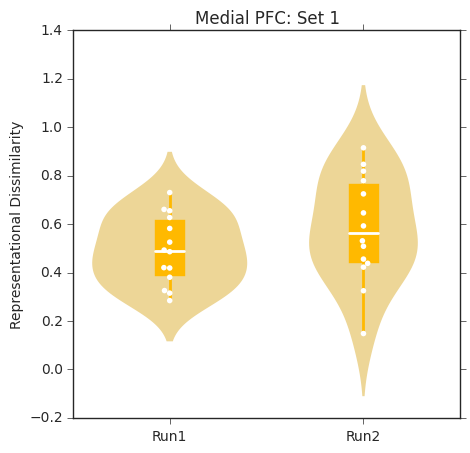

Set2 Run1 vs. Run2:
Wilcoxon (30.0, 0.15781136896845493)
Cohen's d =  -0.771563343952


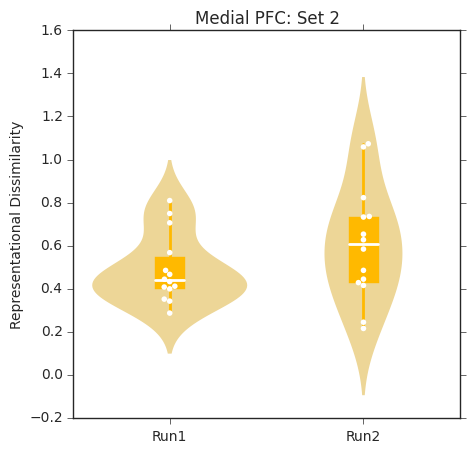

Set3 Run1 vs. Run2:
Wilcoxon (49.0, 0.82609102885882013)
Cohen's d =  -0.104383355186


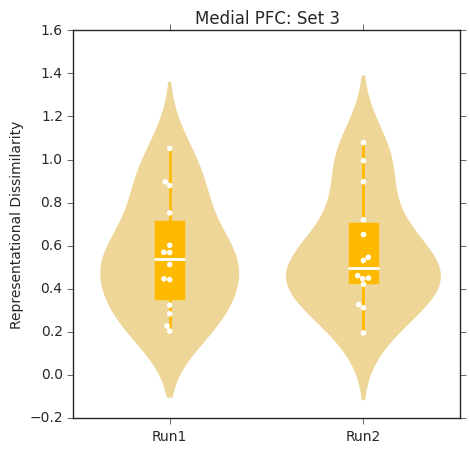

In [11]:
print "Dissimilarity"
for key in ["s1r1", "s1r2","s2r1","s2r2","s3r1","s3r2"]:
    print "Mean {0}: ".format(key), np.mean(all_corrs_df['mpfc']['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(all_corrs_df['mpfc']['{0}'.format(key)])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1', 'Run2']
    mpfc_allsubjs = [all_corrs_df['mpfc']['s{0}r1'.format(i+1)], all_corrs_df['mpfc']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=mpfc_allsubjs, color="#ffde85", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="#ffb900", facecolor="#ffb900"),
               whiskerprops=dict(color="#ffb900", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = mpfc_allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity")
    ax.set_title("Medial PFC: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.ttest_rel(all_corrs_df['mpfc']['s{0}r1'.format(i+1)], all_corrs_df['mpfc']['s{0}r2'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['mpfc']['s{0}r1'.format(i+1)], all_corrs_df['mpfc']['s{0}r2'.format(i+1)])[:], "<---- **"
    else:
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['mpfc']['s{0}r1'.format(i+1)], all_corrs_df['mpfc']['s{0}r2'.format(i+1)])[:]
    cohens_d = ((np.average(all_corrs_df['mpfc']['s{0}r1'.format(i+1)]) 
                 - np.average(all_corrs_df['mpfc']['s{0}r2'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['mpfc']['s{0}r1'.format(i+1)], ddof = 1)) 
                    ** 2 + np.std(all_corrs_df['mpfc']['s{0}r2'.format(i+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d
    #plt.savefig("/home/arenf001/figs/RSA1C_mpfc_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (0.17137477931347955, 0.558007607635715)
Late - Run1: (0.32860689160985179, 0.25133312351890291)


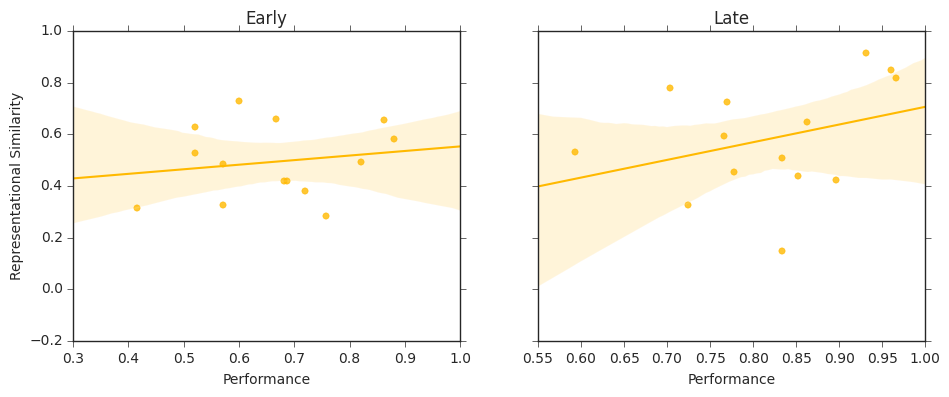

SET 2
Early - Run1: (0.14298073421895172, 0.62581571181080298)
Late - Run1: (0.60801573317870516, 0.021064696444070535)


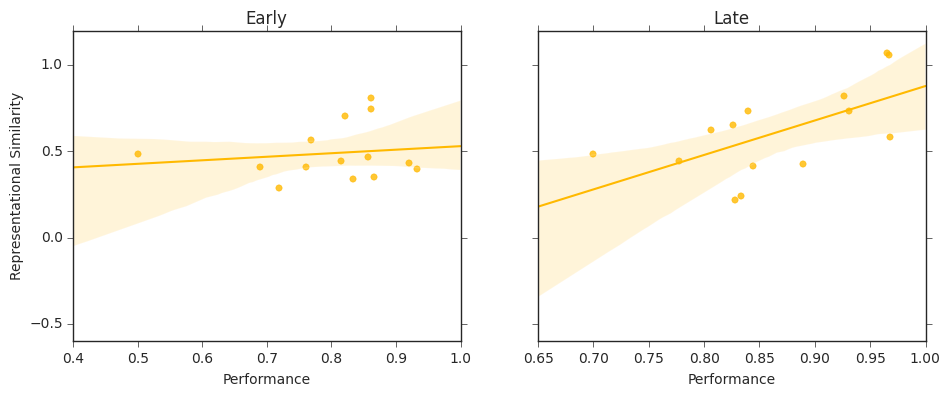

SET 3
Early - Run1: (0.41619665043084592, 0.1388149938918451)
Late - Run1: (0.44502505325483094, 0.11081752027207759)


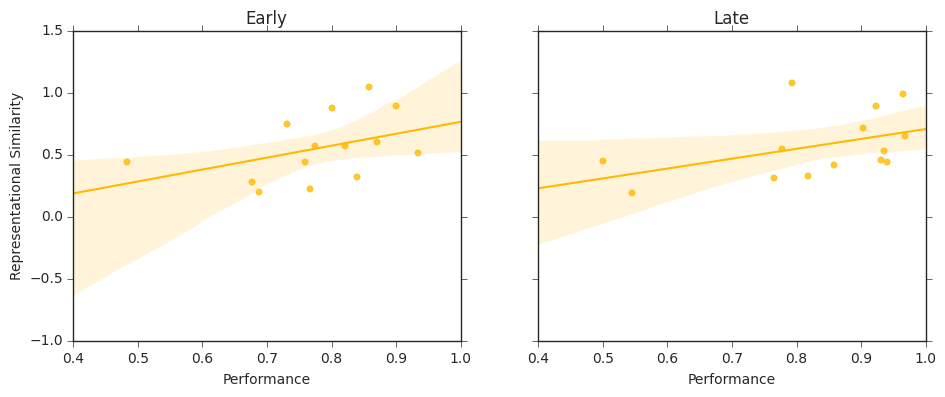

In [12]:
for i in range(3):
    mpfc_early_plot = {}
    mpfc_early_plot['brain'] = all_corrs_df['mpfc']['s{0}r1'.format(i+1)]
    mpfc_early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    mpfc_early_plot = pd.DataFrame(mpfc_early_plot)
    mpfc_late_plot = {}
    mpfc_late_plot['brain'] = all_corrs_df['mpfc']['s{0}r2'.format(i+1)]
    mpfc_late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    mpfc_late_plot = pd.DataFrame(mpfc_late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(mpfc_early_plot['brain'],mpfc_early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(mpfc_early_plot['brain'],mpfc_early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(mpfc_early_plot['brain'],mpfc_early_plot['behavior'])[:]
    if pearsonr(mpfc_late_plot['brain'],mpfc_late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(mpfc_late_plot['brain'],mpfc_late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(mpfc_late_plot['brain'],mpfc_late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11, 4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = mpfc_early_plot, color = "#ffb900", ax = ax1)
    ax1.set_ylabel('Representational Similarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = mpfc_late_plot, color = "#ffb900", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2C_mpfc_run{0}.png".format(i+1), dpi = 800)
    plt.show()

## Caudate

Dissimilarity
Mean s1r1:  0.503780856729
STD s1r1:  0.110036545836

Mean s1r2:  0.656227784497
STD s1r2:  0.198311445029

Mean s2r1:  0.574382443513
STD s2r1:  0.11389296136

Mean s2r2:  0.638579488865
STD s2r2:  0.178763630463

Mean s3r1:  0.523985896792
STD s3r1:  0.151480032425

Mean s3r2:  0.643583376493
STD s3r2:  0.142881978802

Set1 Run1 vs. Run2:
Wilcoxon (28.0, 0.12404279309009482)
Cohen's d =  -1.29546287456


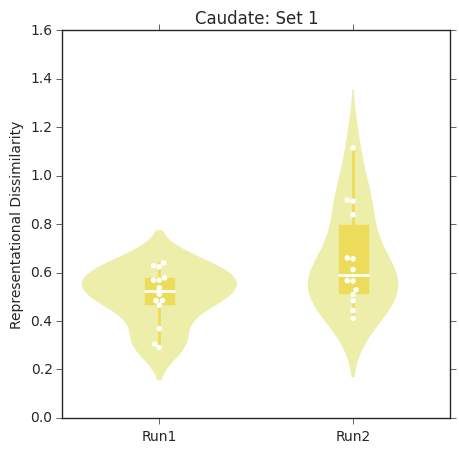

Set2 Run1 vs. Run2:
Wilcoxon (36.0, 0.30028987962532416)
Cohen's d =  -0.583705717217


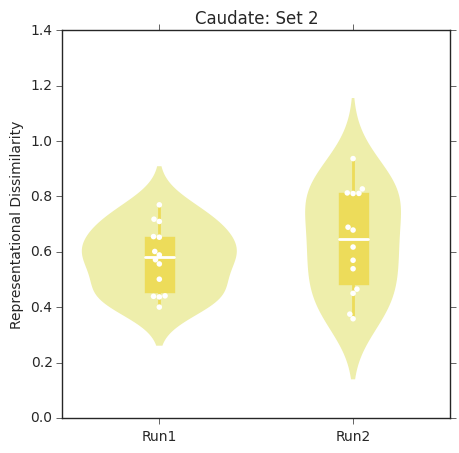

Set3 Run1 vs. Run2:
Wilcoxon (12.0, 0.011007912955186742) <---- **
Cohen's d =  -1.10689833194


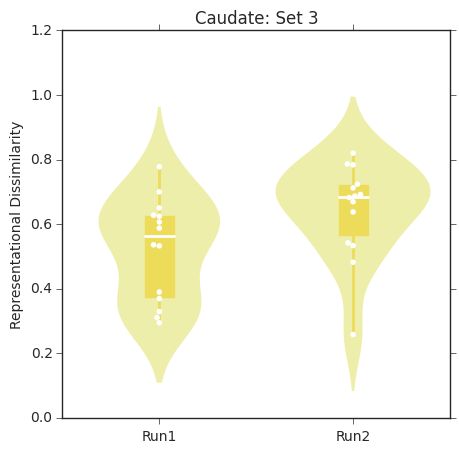

In [13]:
print "Dissimilarity"
for key in ["s1r1","s1r2","s2r1","s2r2","s3r1","s3r2"]:
    print "Mean {0}: ".format(key), np.mean(all_corrs_df['caud']['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(all_corrs_df['caud']['{0}'.format(key)])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1','Run2']
    caud_allsubjs = [all_corrs_df['caud']['s{0}r1'.format(i+1)], all_corrs_df['caud']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=caud_allsubjs, color="#fcfc9d", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(caud_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="#eddc5a", facecolor="#eddc5a"),
               whiskerprops=dict(color="#eddc5a", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = caud_allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity")
    ax.set_title("Caudate: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.ttest_rel(all_corrs_df['caud']['s{0}r1'.format(i+1)], all_corrs_df['caud']['s{0}r2'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['caud']['s{0}r1'.format(i+1)], all_corrs_df['caud']['s{0}r2'.format(i+1)])[:], "<---- **"
    else:
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['caud']['s{0}r1'.format(i+1)], all_corrs_df['caud']['s{0}r2'.format(i+1)])[:]
    cohens_d = ((np.average(all_corrs_df['caud']['s{0}r1'.format(i+1)]) 
                 - np.average(all_corrs_df['caud']['s{0}r2'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['caud']['s{0}r1'.format(i+1)], ddof = 1)) 
                    ** 2 + np.std(all_corrs_df['caud']['s{0}r2'.format(i+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1C_caud_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (0.32414008421598428, 0.25821830399013956)
Late - Run1: (0.41577367438730795, 0.1392578085455182)


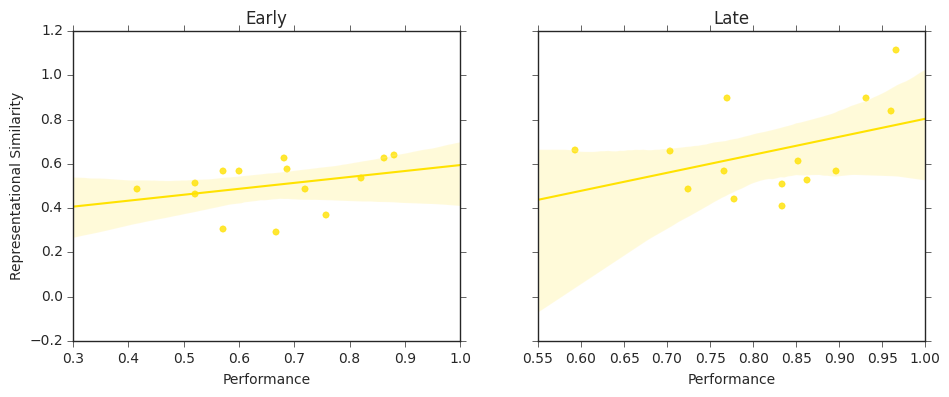

SET 2
Early - Run1: (0.48742265080682623, 0.077078009391304575)
Late - Run1: (0.30471604379497064, 0.28946275123096377)


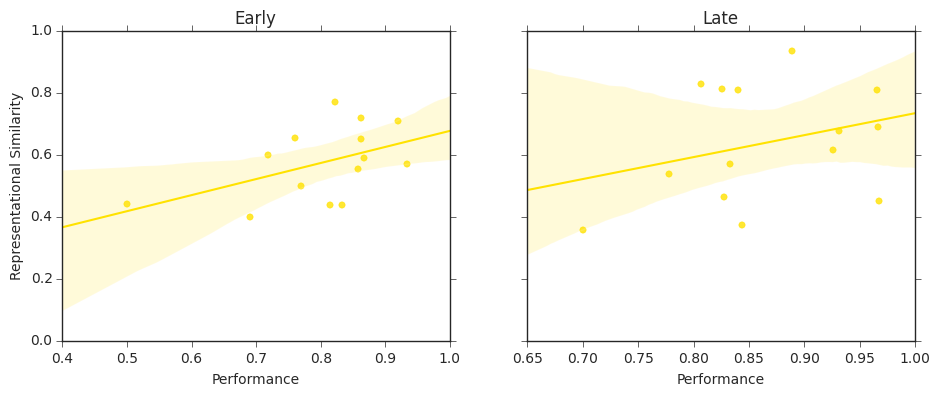

SET 3
Early - Run1: (0.39376688563860629, 0.16361117442000833)
Late - Run1: (0.78748025049038395, 0.00082687748400930806) <---- **


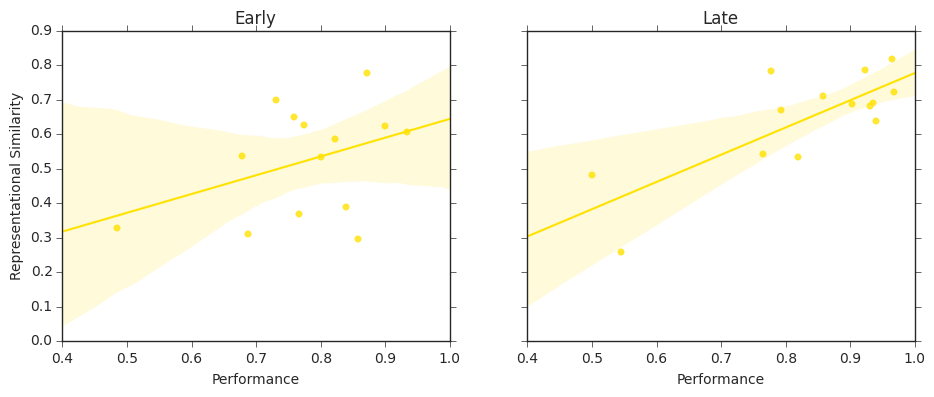

In [14]:
for i in range(3):
    caud_early_plot = {}
    caud_early_plot['brain'] = all_corrs_df['caud']['s{0}r1'.format(i+1)]
    caud_early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    caud_early_plot = pd.DataFrame(caud_early_plot)
    caud_late_plot = {}
    caud_late_plot['brain'] = all_corrs_df['caud']['s{0}r2'.format(i+1)]
    caud_late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    caud_late_plot = pd.DataFrame(caud_late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(caud_early_plot['brain'],caud_early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(caud_early_plot['brain'],caud_early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(caud_early_plot['brain'],caud_early_plot['behavior'])[:]
    if pearsonr(caud_late_plot['brain'],caud_late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(caud_late_plot['brain'],caud_late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(caud_late_plot['brain'],caud_late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11,4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = caud_early_plot, color = "#ffe200", ax = ax1)
    ax1.set_ylabel('Representational Similarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = caud_late_plot, color = "#ffe200", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2C_caud_run{0}.png".format(i+1), dpi = 800)    
    plt.show()

## Putamen

Dissimilarity
Mean s1r1:  0.551874681243
STD s1r1:  0.100193948625

Mean s1r2:  0.610966893711
STD s1r2:  0.135477605478

Mean s2r1:  0.602243553315
STD s2r1:  0.0962896303194

Mean s2r2:  0.630160853267
STD s2r2:  0.14515718196

Mean s3r1:  0.515508770943
STD s3r1:  0.127342874354

Mean s3r2:  0.65155914213
STD s3r2:  0.153865798168

Set1 Run1 vs. Run2:
Wilcoxon (46.0, 0.68323907162659103)
Cohen's d =  -0.675868483322


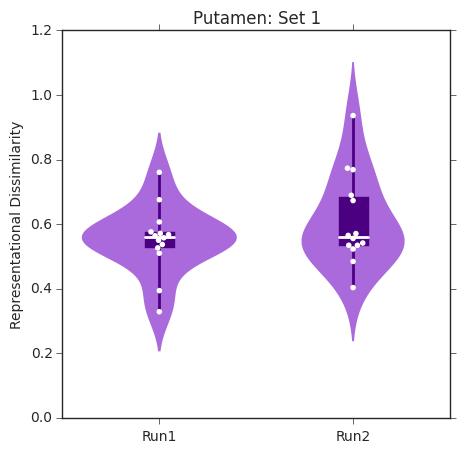

Set2 Run1 vs. Run2:
Wilcoxon (42.0, 0.50979748496086386)
Cohen's d =  -0.308877885127


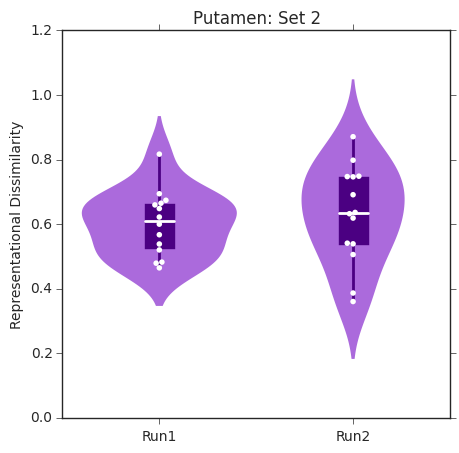

Set3 Run1 vs. Run2:
Wilcoxon (7.0, 0.0042856952994814864) <---- **
Cohen's d =  -1.312805882


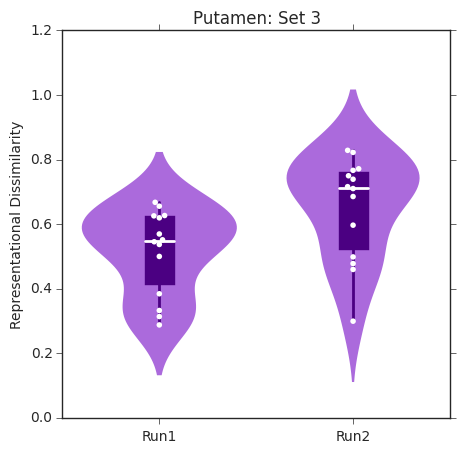

In [15]:
print "Dissimilarity"
for key in ["s1r1","s1r2","s2r1","s2r2","s3r1","s3r2"]:
    print "Mean {0}: ".format(key), np.mean(all_corrs_df['put']['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(all_corrs_df['put']['{0}'.format(key)])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1','Run2']
    put_allsubjs = [all_corrs_df['put']['s{0}r1'.format(i+1)], all_corrs_df['put']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=put_allsubjs, color="#af52f4", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
               whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = put_allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity")
    ax.set_title("Putamen: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.ttest_rel(all_corrs_df['put']['s{0}r1'.format(i+1)], all_corrs_df['put']['s{0}r2'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['put']['s{0}r1'.format(i+1)], all_corrs_df['put']['s{0}r2'.format(i+1)])[:], "<---- **"
    else:
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['put']['s{0}r1'.format(i+1)], all_corrs_df['put']['s{0}r2'.format(i+1)])[:]
    cohens_d = ((np.average(all_corrs_df['put']['s{0}r1'.format(i+1)]) 
                 - np.average(all_corrs_df['put']['s{0}r2'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['put']['s{0}r1'.format(i+1)], ddof = 1)) 
                    ** 2 + np.std(all_corrs_df['put']['s{0}r2'.format(i+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1C_put_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (-0.00047849465484989245, 0.99870470051071158)
Late - Run1: (0.58669387446970456, 0.027423529138640743)


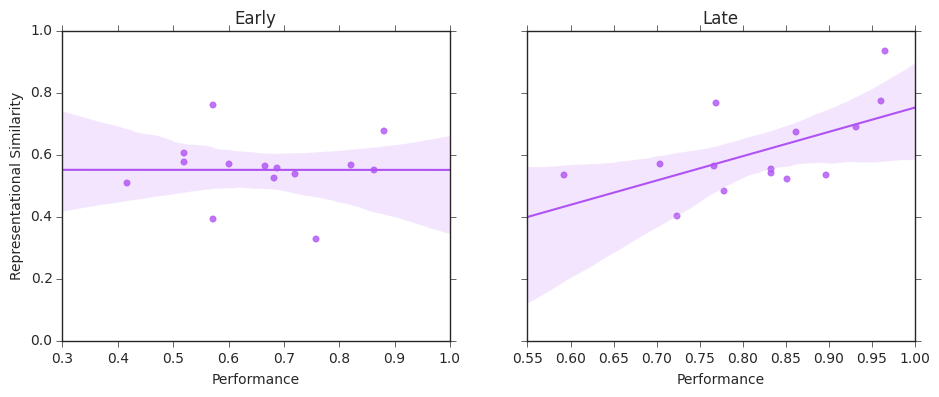

SET 2
Early - Run1: (0.56370410149854522, 0.035780615932844304)
Late - Run1: (0.66223780728157333, 0.009869132572961346)


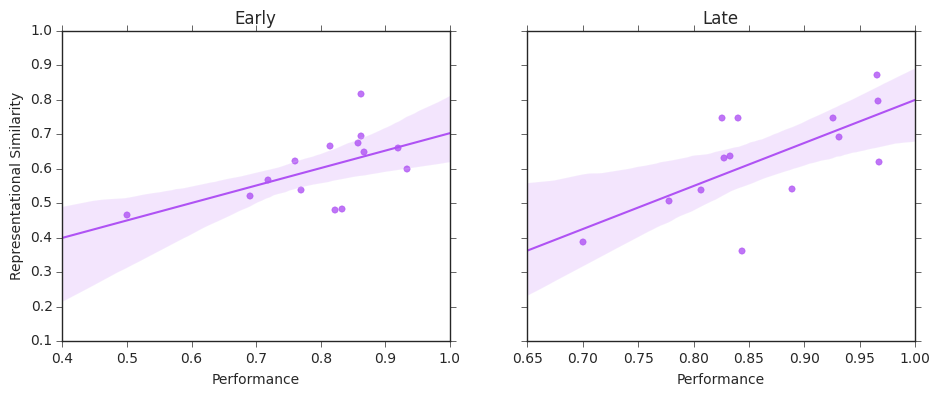

SET 3
Early - Run1: (0.51661464525762835, 0.058561960369452257)
Late - Run1: (0.77055506389332873, 0.0012586051349831957) <---- **


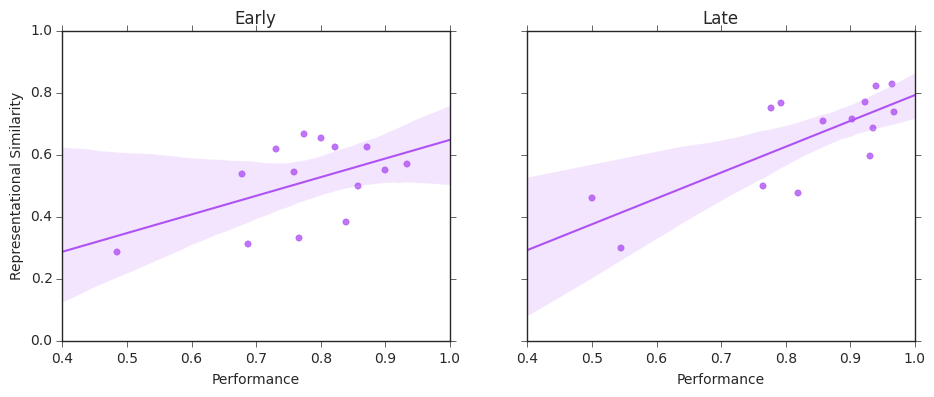

In [16]:
for i in range(3):
    put_early_plot = {}
    put_early_plot['brain'] = all_corrs_df['put']['s{0}r1'.format(i+1)]
    put_early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    put_early_plot = pd.DataFrame(put_early_plot)
    put_late_plot = {}
    put_late_plot['brain'] = all_corrs_df['put']['s{0}r2'.format(i+1)]
    put_late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    put_late_plot = pd.DataFrame(put_late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(put_early_plot['brain'],put_early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(put_early_plot['brain'],put_early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(put_early_plot['brain'],put_early_plot['behavior'])[:]
    if pearsonr(put_late_plot['brain'],put_late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(put_late_plot['brain'],put_late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(put_late_plot['brain'],put_late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11,4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = put_early_plot, color = "#af52f4", ax = ax1)
    ax1.set_ylabel('Representational Similarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = put_late_plot, color = "#af52f4", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2C_put_run{0}.png".format(i+1), dpi = 800)
    plt.show()

## Dorsolateral PFC

Dissimilarity
Mean s1r1:  0.51001810176
STD s1r1:  0.120499114075

Mean s1r2:  0.599142970783
STD s1r2:  0.184501582569

Mean s2r1:  0.52351458211
STD s2r1:  0.173040426198

Mean s2r2:  0.590128623481
STD s2r2:  0.16432828635

Mean s3r1:  0.545455270979
STD s3r1:  0.222113932884

Mean s3r2:  0.556660579784
STD s3r2:  0.152037579872

Set1 Run1 vs. Run2:
t-test (-1.2727832644278407, 0.22538716496572173)
Cohen's d =  -0.779459091795


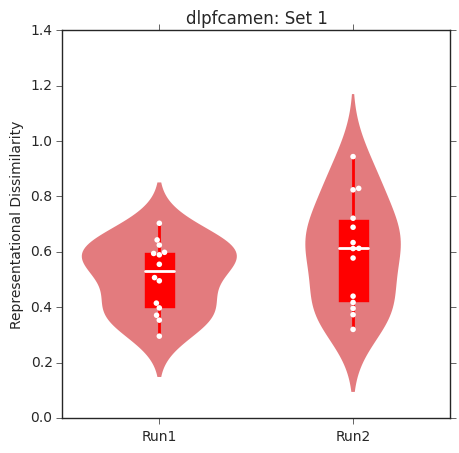

Set2 Run1 vs. Run2:
t-test (-1.0910122545295597, 0.29507633725057203)
Cohen's d =  -0.537983393548


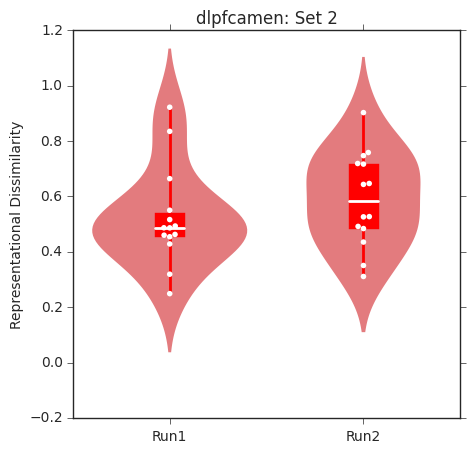

Set3 Run1 vs. Run2:
t-test (-0.20513455862387986, 0.84064410251150168)
Cohen's d =  -0.0802310016427


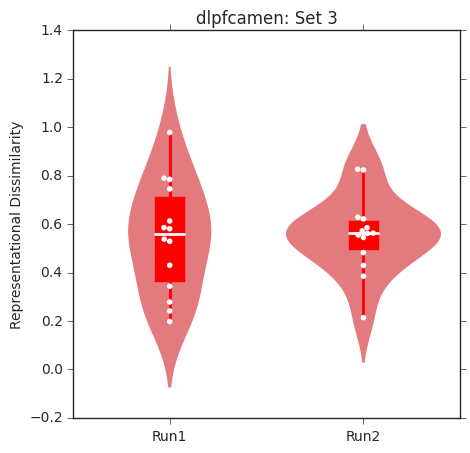

In [17]:
print "Dissimilarity"
for key in ["s1r1","s1r2","s2r1","s2r2","s3r1","s3r2"]:
    print "Mean {0}: ".format(key), np.mean(all_corrs_df['dlpfc']['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(all_corrs_df['dlpfc']['{0}'.format(key)])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1','Run2']
    dlpfc_allsubjs = [all_corrs_df['dlpfc']['s{0}r1'.format(i+1)], all_corrs_df['dlpfc']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=dlpfc_allsubjs, color="#fa6469", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(dlpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="red", facecolor="red"),
               whiskerprops=dict(color="red", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = dlpfc_allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity")
    ax.set_title("dlpfcamen: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.ttest_rel(all_corrs_df['dlpfc']['s{0}r1'.format(i+1)], all_corrs_df['dlpfc']['s{0}r2'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
        print "t-test", stats.ttest_rel(all_corrs_df['dlpfc']['s{0}r1'.format(i+1)], all_corrs_df['dlpfc']['s{0}r2'.format(i+1)])[:], "<---- **"
    else:
        print "t-test", stats.ttest_rel(all_corrs_df['dlpfc']['s{0}r1'.format(i+1)], all_corrs_df['dlpfc']['s{0}r2'.format(i+1)])[:]
    cohens_d = ((np.average(all_corrs_df['dlpfc']['s{0}r1'.format(i+1)]) 
                 - np.average(all_corrs_df['dlpfc']['s{0}r2'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['dlpfc']['s{0}r1'.format(i+1)], ddof = 1)) 
                    ** 2 + np.std(all_corrs_df['dlpfc']['s{0}r2'.format(i+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1C_dlpfc_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (0.3199136184552609, 0.26483641740786951)
Late - Run1: (0.5383186496296074, 0.04704600118832275)


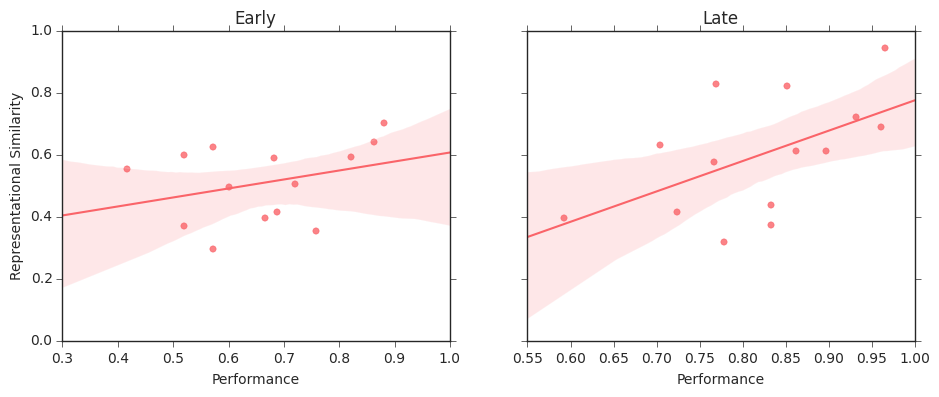

SET 2
Early - Run1: (0.39600460669019094, 0.16101592066826251)
Late - Run1: (0.69234946769428907, 0.0060667208922696222) <---- **


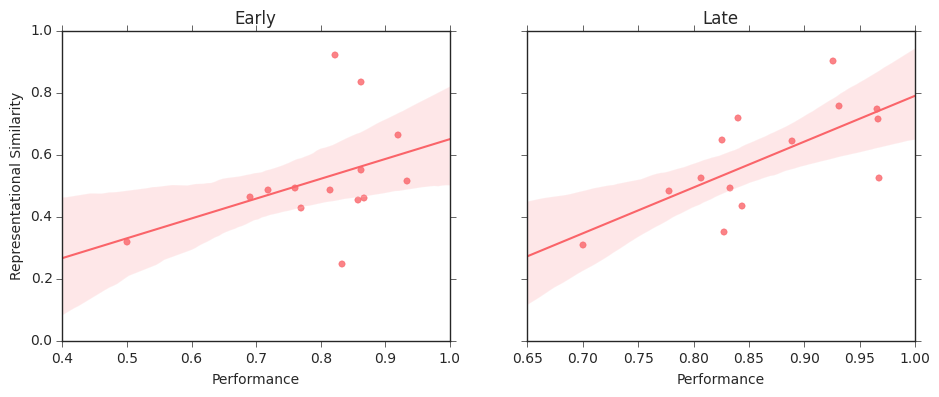

SET 3
Early - Run1: (0.55655711568669841, 0.038725549347865415)
Late - Run1: (0.51892462371641046, 0.057248533748571737)


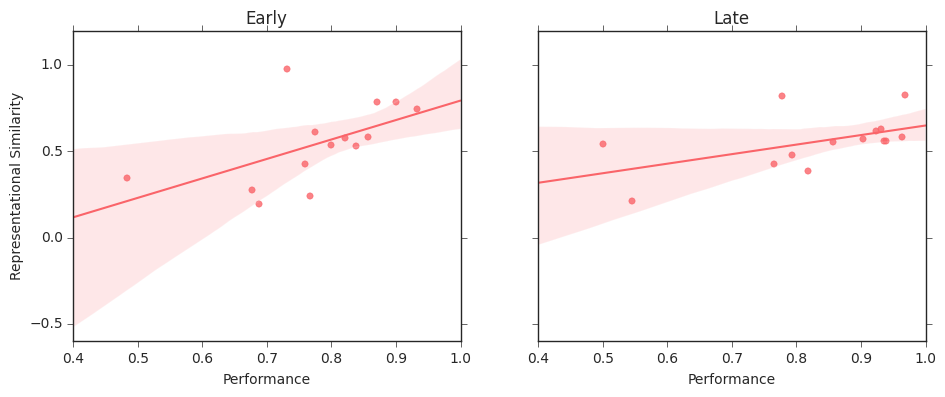

In [18]:
for i in range(3):
    dlpfc_early_plot = {}
    dlpfc_early_plot['brain'] = all_corrs_df['dlpfc']['s{0}r1'.format(i+1)]
    dlpfc_early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    dlpfc_early_plot = pd.DataFrame(dlpfc_early_plot)
    dlpfc_late_plot = {}
    dlpfc_late_plot['brain'] = all_corrs_df['dlpfc']['s{0}r2'.format(i+1)]
    dlpfc_late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    dlpfc_late_plot = pd.DataFrame(dlpfc_late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(dlpfc_early_plot['brain'],dlpfc_early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(dlpfc_early_plot['brain'],dlpfc_early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(dlpfc_early_plot['brain'],dlpfc_early_plot['behavior'])[:]
    if pearsonr(dlpfc_late_plot['brain'],dlpfc_late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(dlpfc_late_plot['brain'],dlpfc_late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(dlpfc_late_plot['brain'],dlpfc_late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11,4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = dlpfc_early_plot, color = "#fa6469", ax = ax1)
    ax1.set_ylabel('Representational Similarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = dlpfc_late_plot, color = "#fa6469", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2C_dlpfc_run{0}.png".format(i+1), dpi = 800)
    plt.show()

## Ventral Occipital

Dissimilarity
Mean s1r1:  0.473633918379
STD s1r1:  0.141846768992

Mean s1r2:  0.442241349391
STD s1r2:  0.148352237

Mean s2r1:  0.453067200524
STD s2r1:  0.150563380835

Mean s2r2:  0.429448091558
STD s2r2:  0.112103274333

Mean s3r1:  0.454226306507
STD s3r1:  0.184884768031

Mean s3r2:  0.440484587635
STD s3r2:  0.134203741369

Set1 Run1 vs. Run2:
Wilcoxon (41.0, 0.47033779626139649)
Cohen's d =  0.294764034517


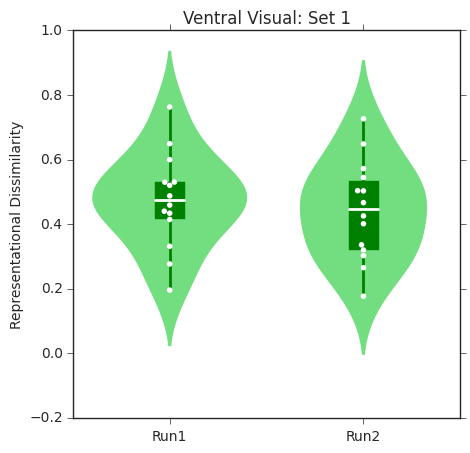

Set2 Run1 vs. Run2:
Wilcoxon (49.0, 0.82609102885882013)
Cohen's d =  0.242496196482


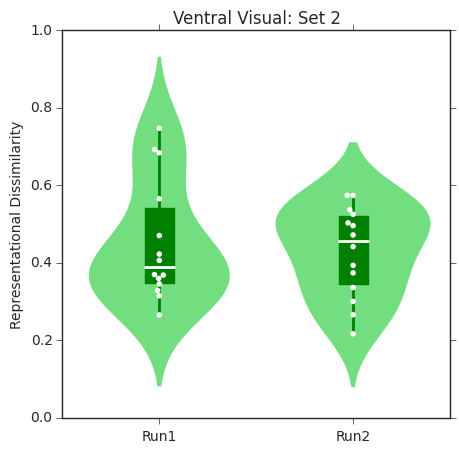

Set3 Run1 vs. Run2:
Wilcoxon (49.0, 0.82609102885882013)
Cohen's d =  0.115923769109


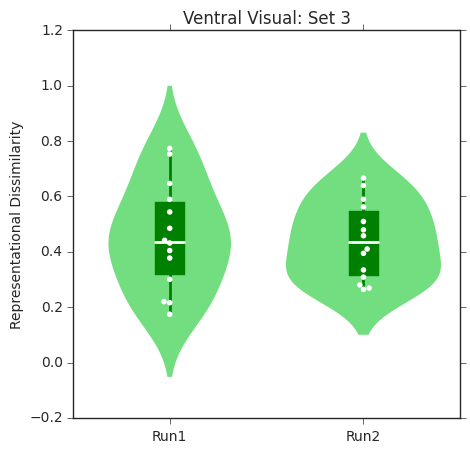

In [19]:
print "Dissimilarity"
for key in ["s1r1","s1r2","s2r1","s2r2","s3r1","s3r2"]:
    print "Mean {0}: ".format(key), np.mean(all_corrs_df['vocc']['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(all_corrs_df['vocc']['{0}'.format(key)])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1','Run2']
    vocc_allsubjs = [all_corrs_df['vocc']['s{0}r1'.format(i+1)], all_corrs_df['vocc']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=vocc_allsubjs, color="#5bf56f", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(vocc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="green", facecolor="green"),
               whiskerprops=dict(color="green", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = vocc_allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity")
    ax.set_title("Ventral Visual: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.ttest_rel(all_corrs_df['vocc']['s{0}r1'.format(i+1)], all_corrs_df['vocc']['s{0}r2'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['vocc']['s{0}r1'.format(i+1)], all_corrs_df['vocc']['s{0}r2'.format(i+1)])[:], "<---- **"
    else:
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['vocc']['s{0}r1'.format(i+1)], all_corrs_df['vocc']['s{0}r2'.format(i+1)])[:]
    cohens_d = ((np.average(all_corrs_df['vocc']['s{0}r1'.format(i+1)]) 
                 - np.average(all_corrs_df['vocc']['s{0}r2'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['vocc']['s{0}r1'.format(i+1)], ddof = 1)) 
                    ** 2 + np.std(all_corrs_df['vocc']['s{0}r2'.format(i+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d  
    #plt.savefig("/home/arenf001/figs/RSA1C_vocc_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (-0.11441003655922441, 0.69694000778087162)
Late - Run1: (0.30652350541463907, 0.28646612513621905)


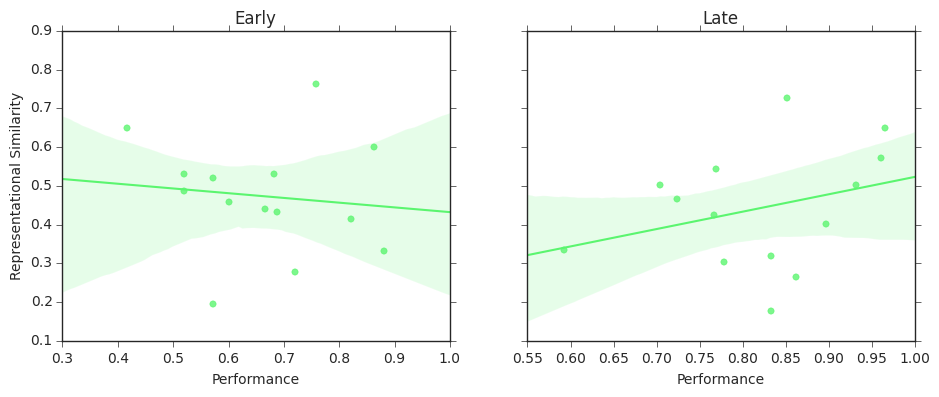

SET 2
Early - Run1: (0.20178230579667883, 0.48907707762584418)
Late - Run1: (0.38862862767295075, 0.16967347199182178)


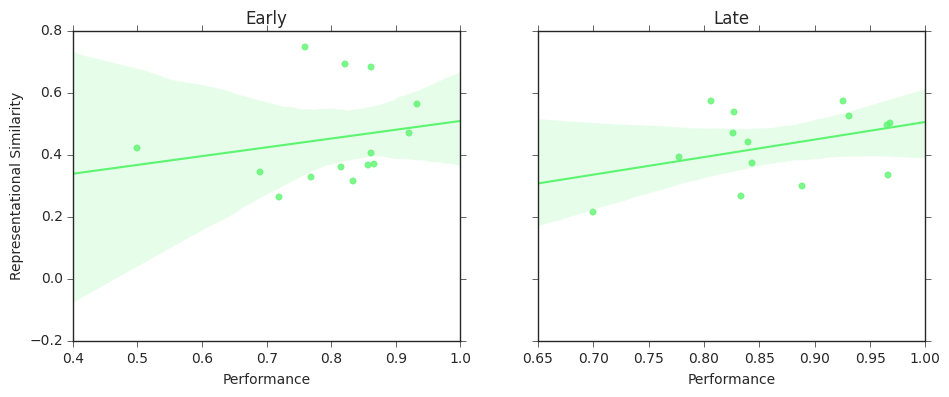

SET 3
Early - Run1: (0.71145523148724121, 0.0043248982496944949) <---- **
Late - Run1: (0.340894552909145, 0.23297257392039825)


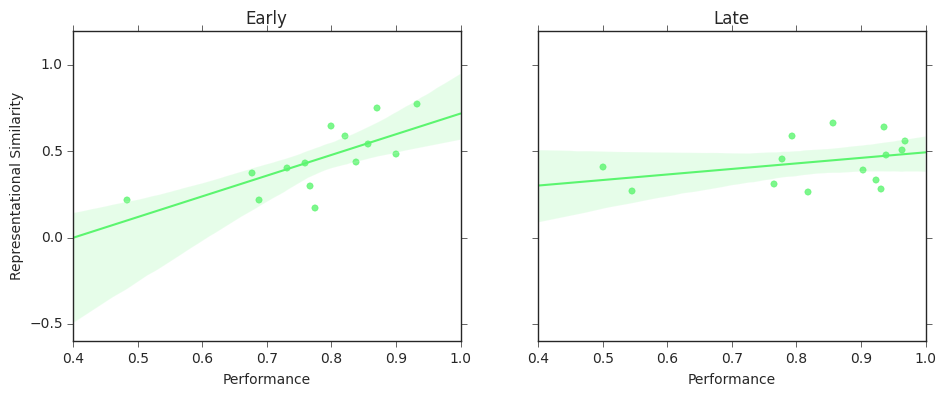

In [20]:
for i in range(3):
    vocc_early_plot = {}
    vocc_early_plot['brain'] = all_corrs_df['vocc']['s{0}r1'.format(i+1)]
    vocc_early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    vocc_early_plot = pd.DataFrame(vocc_early_plot)
    vocc_late_plot = {}
    vocc_late_plot['brain'] = all_corrs_df['vocc']['s{0}r2'.format(i+1)]
    vocc_late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    vocc_late_plot = pd.DataFrame(vocc_late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(vocc_early_plot['brain'],vocc_early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(vocc_early_plot['brain'],vocc_early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(vocc_early_plot['brain'],vocc_early_plot['behavior'])[:]
    if pearsonr(vocc_late_plot['brain'],vocc_late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(vocc_late_plot['brain'],vocc_late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(vocc_late_plot['brain'],vocc_late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11,4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = vocc_early_plot, color = "#5bf56f", ax = ax1)
    ax1.set_ylabel('Representational Similarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = vocc_late_plot, color = "#5bf56f", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2C_vocc_run{0}.png".format(i+1), dpi = 800)
    plt.show()

## Retrosplenial Cortex

Dissimilarity
Mean s1r1:  0.488759828332
STD s1r1:  0.228823092031

Mean s1r2:  0.544910252493
STD s1r2:  0.231852706707

Mean s2r1:  0.459588343011
STD s2r1:  0.211865552855

Mean s2r2:  0.526487727317
STD s2r2:  0.226931369426

Mean s3r1:  0.519478180047
STD s3r1:  0.318306843824

Mean s3r2:  0.530930121296
STD s3r2:  0.254193936954

Set1 Run1 vs. Run2:
Wilcoxon (43.0, 0.55092368277340698)
Cohen's d =  -0.332200976106


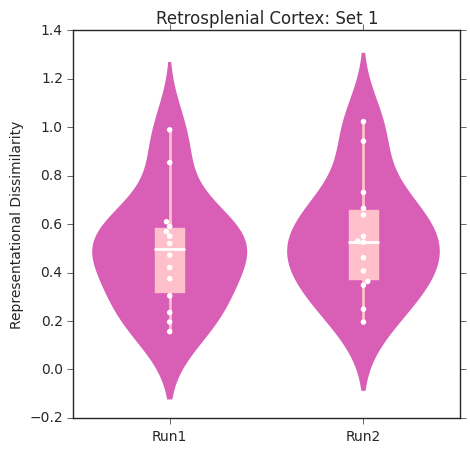

Set2 Run1 vs. Run2:
Wilcoxon (42.0, 0.50979748496086386)
Cohen's d =  -0.415293722861


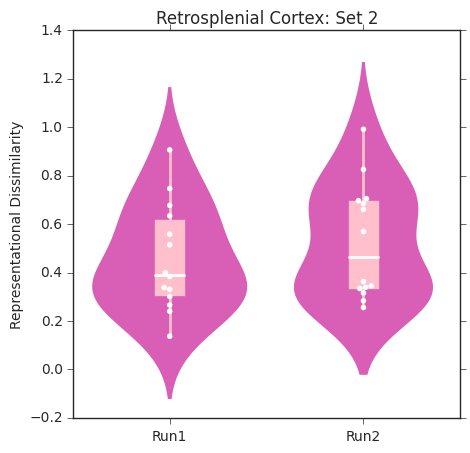

Set3 Run1 vs. Run2:
Wilcoxon (41.0, 0.47033779626139649)
Cohen's d =  -0.0541812886483


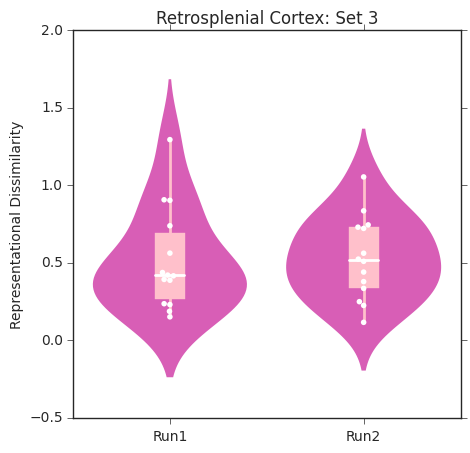

In [21]:
print "Dissimilarity"
for key in ["s1r1","s1r2","s2r1","s2r2","s3r1","s3r2"]:
    print "Mean {0}: ".format(key), np.mean(all_corrs_df['rsc']['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(all_corrs_df['rsc']['{0}'.format(key)])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1','Run2']
    rsc_allsubjs = [all_corrs_df['rsc']['s{0}r1'.format(i+1)], all_corrs_df['rsc']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=rsc_allsubjs, color="#f244c1", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(rsc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="pink", facecolor="pink"),
               whiskerprops=dict(color="pink", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = rsc_allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity")
    ax.set_title("Retrosplenial Cortex: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.ttest_rel(all_corrs_df['rsc']['s{0}r1'.format(i+1)], all_corrs_df['rsc']['s{0}r2'.format(i+1)])[:][-1] < 0.017:
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['rsc']['s{0}r1'.format(i+1)], all_corrs_df['rsc']['s{0}r2'.format(i+1)])[:], "<---- **"
    else:
        print "Wilcoxon", stats.wilcoxon(all_corrs_df['rsc']['s{0}r1'.format(i+1)], all_corrs_df['rsc']['s{0}r2'.format(i+1)])[:]
    cohens_d = ((np.average(all_corrs_df['rsc']['s{0}r1'.format(i+1)]) 
                 - np.average(all_corrs_df['rsc']['s{0}r2'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['rsc']['s{0}r1'.format(i+1)], ddof = 1)) 
                    ** 2 + np.std(all_corrs_df['rsc']['s{0}r2'.format(i+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1C_rsc_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (0.35836932898229412, 0.20832439545888981)
Late - Run1: (0.49791836920156668, 0.070001535449891378)


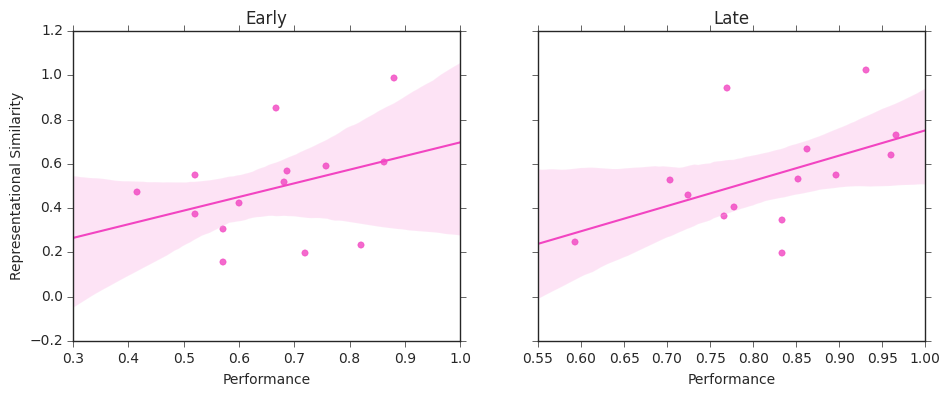

SET 2
Early - Run1: (0.46034436446650578, 0.097639992145728743)
Late - Run1: (0.35402022336466626, 0.21429855309765519)


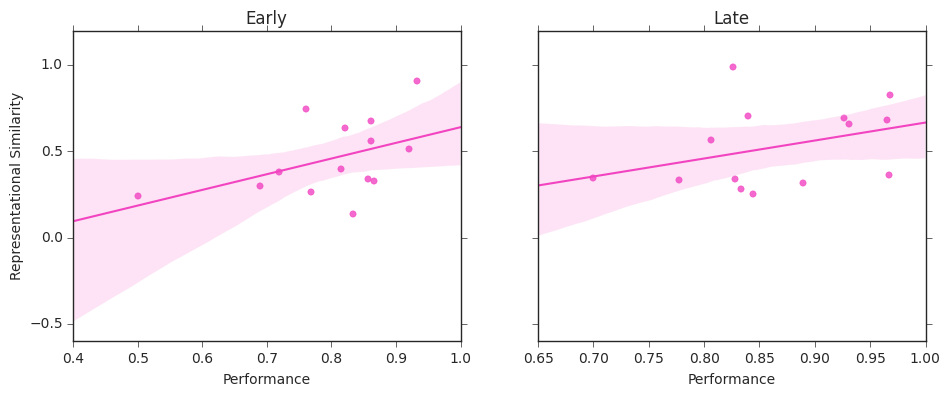

SET 3
Early - Run1: (0.56989996365511431, 0.033364452997077208)
Late - Run1: (0.26060262558264652, 0.36819107447493221)


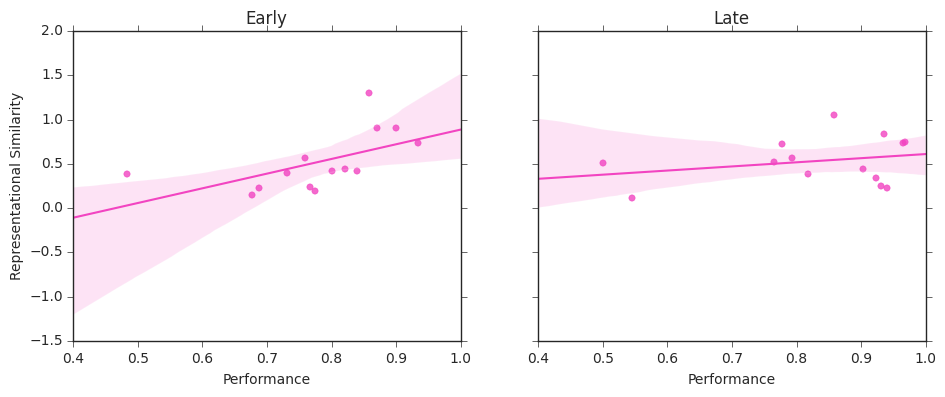

In [22]:
for i in range(3):
    rsc_early_plot = {}
    rsc_early_plot['brain'] = all_corrs_df['rsc']['s{0}r1'.format(i+1)]
    rsc_early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    rsc_early_plot = pd.DataFrame(rsc_early_plot)
    rsc_late_plot = {}
    rsc_late_plot['brain'] = all_corrs_df['rsc']['s{0}r2'.format(i+1)]
    rsc_late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    rsc_late_plot = pd.DataFrame(rsc_late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(rsc_early_plot['brain'],rsc_early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(rsc_early_plot['brain'],rsc_early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(rsc_early_plot['brain'],rsc_early_plot['behavior'])[:]
    if pearsonr(rsc_late_plot['brain'],rsc_late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(rsc_late_plot['brain'],rsc_late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(rsc_late_plot['brain'],rsc_late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11,4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = rsc_early_plot, color = "#f244c1", ax = ax1)
    ax1.set_ylabel('Representational Similarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = rsc_late_plot, color = "#f244c1", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2C_rsc_run{0}.png".format(i+1), dpi = 800)
    plt.show()